# Library

In [ ]:
# default setting
import os
import gc
import pickle
from tqdm import tqdm
from numba import cuda
from itertools import product

# data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# model evaluation
from lightgbm import plot_importance
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# model pred
from lightgbm import LGBMClassifier
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.layers.merge import concatenate

# model interpretor
import lime
import lime.lime_tabular

os.chdir(r'C:\Users\styli\Desktop\빅콘 최종 돌리기 LGBM') #상대 경로 지정

# 1. 로그 데이터 전처리

## 1.1 LOG 데이터 전처리 - 결측값 제거

로그 데이터 임포트.

In [ ]:
log_data = pd.read_csv('log_data.csv')

log_data의 타입 확인

In [ ]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17843993 entries, 0 to 17843992
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   event           object
 2   timestamp       object
 3   mp_os           object
 4   mp_app_version  object
 5   date_cd         object
dtypes: int64(1), object(5)
memory usage: 816.8+ MB


timestamp를 datetime형으로 변환, user_id, timestamp 순으로 졍렬

In [ ]:
log_data['timestamp'] = pd.to_datetime(log_data['timestamp'])
log_data = log_data.sort_values(['user_id', 'timestamp'])

log_data에 존재하는 결측값.

In [ ]:
print(log_data.isna().sum())

user_id                0
event                  0
timestamp              0
mp_os                980
mp_app_version    660597
date_cd                0
dtype: int64


유저별로 이전에 존재하는 로그 데이터로 결측값 메우기

In [ ]:
ndf = []
for idx, df in tqdm(log_data.groupby('user_id')):
    ndf.append(df.fillna(method='ffill'))

log_data = pd.concat(ndf, axis = 0, ignore_index=True)

print(log_data.isna().sum())

100%|██████████| 584636/584636 [05:56<00:00, 1638.45it/s]


user_id               0
event                 0
timestamp             0
mp_os                50
mp_app_version    83973
date_cd               0
dtype: int64


유저별로 이후에 존재하는 로그 데이터로 결측값 메우기

In [ ]:
counter = 0; ndf = []
for idx, df in tqdm(log_data.groupby('user_id')):
    ndf.append(df.fillna(method='bfill'))

log_data = pd.concat(ndf, axis = 0, ignore_index=True)

# 개수 체크
print(log_data.isna().sum())

100%|██████████| 584636/584636 [06:29<00:00, 1499.18it/s]


user_id               0
event                 0
timestamp             0
mp_os                14
mp_app_version    32571
date_cd               0
dtype: int64


결측이 해결되지 않은 값들에 대해, os를 android로, version을 unknown으로 대체하기

In [ ]:
counter = 0; ndf = []
for idx, df in tqdm(log_data.groupby('user_id')):
    line = df
    line.mp_os = line.mp_os.fillna('Android')
    line.mp_app_version = line.mp_app_version.fillna('unknown')

    ndf.append(line)

log_data = pd.concat(ndf, axis = 0, ignore_index=True)

print(log_data.isna().sum())

100%|██████████| 584636/584636 [06:59<00:00, 1394.41it/s]


user_id           0
event             0
timestamp         0
mp_os             0
mp_app_version    0
date_cd           0
dtype: int64


파일로 저장

In [ ]:
log_data.to_csv('NA_fill_log_data.csv', index=False)

## 1.2 LOG 데이터 전처리 - 유저의 최근 4주 로그에 대해 이용횟수, 업데이트 횟수, 최근 os, version 조사.

데이터 임포트

In [ ]:
log_data = pd.read_csv('NA_fill_log_data.csv')
usr_data = pd.read_csv('user_spec.csv')

유저별로 이벤트가 발생한 횟수를 측정한 데이터 저장.

In [ ]:
log_data['counter'] = 1

# 이렇게 하면 전처리 끝.
event_count = log_data.pivot_table(index = 'user_id', columns='event', values = 'counter', aggfunc = 'sum').reset_index()

event_count.to_csv('event_count.csv', index=False)

유저별로 어떤 이벤트와 시간, os, 버전에 관한 정보를 가진 "유저-로그 테이블"을 만든다.

In [ ]:
user_log = []

for idx, val in tqdm(log_data.groupby('user_id')):
    event = [i for i in val.event.values]
    mp_os = [i for i in val.mp_os.values]
    mp_app_version = [i for i in val.mp_app_version.values]
    timestamp = [i for i in val.timestamp.values]

    user_log.append(pd.DataFrame({'event': [event], 'mp_os' : [mp_os], 'mp_app_version' : [mp_app_version], 'timestamp' : [timestamp]}, index = [idx]))

user_log = pd.concat(user_log, axis = 0)
user_log = user_log.rename_axis('user_id').reset_index()


# 이 작업을 user_spec에 시간 변수에 따라서, 연산해야한다.
user_log['latest_os'] = user_log['mp_os']
user_log['latest_version'] = user_log['mp_app_version']
user_log['update_times'] = user_log['mp_app_version']

user_log['latest_os'] = user_log['latest_os'].apply(lambda x: x[-1])
user_log['latest_version'] = user_log['latest_version'].apply(lambda x: x[-1])
user_log['update_times'] = user_log['update_times'].apply(lambda x: len(set(x)))


100%|██████████| 584636/584636 [06:29<00:00, 1501.55it/s]


만들어진 "유저-로그 테이블"을 대상으로, 유저의 insert time에 지난 4주 이력만을 가져와 유저 테이블에 결합하는 형태로 전처리를 완료한다.

In [ ]:
event_col = log_data.event.unique()
usr_log_plus = []
null_counter = 0

for i in tqdm(usr_data.index):
    line = usr_data.loc[i]
    finder = user_log[user_log.user_id == line.user_id]
    if finder.empty:
        null_counter += 1
        # print(f'\nDataFrame is empty!, null set num : {null_counter}', end = ' ')
        usr_log_plus.append(pd.concat([pd.DataFrame({'application_id' : [line.application_id], 'user_id' : ['no log'], 'event': ['no log'], 'mp_os' : ['no log'], 'mp_app_version' : ['no log'],
                                                     'timestamp' : ['no log'], 'latest_os' : ['no log'], 'latest_version' : ['no log'],
                                                     'update_times' : ['no log']}, index = [0]),
                                       pd.DataFrame(np.array(['no log' for i in range(len(event_col))]).reshape(1,-1), columns = event_col, index = [0])], axis = 1))
        continue
    time_idx = (pd.to_datetime(line.insert_time) - timedelta(weeks=4) <= pd.Series(finder.timestamp.iloc[0], dtype = 'datetime64[ns]')) & (pd.Series(finder.timestamp.iloc[0], dtype = 'datetime64[ns]') <= line.insert_time)

    event = pd.Series(finder.event.iloc[0])[time_idx].tolist()
    mp_os = pd.Series(finder.mp_os.iloc[0])[time_idx].tolist()
    mp_app_version = pd.Series(finder.mp_app_version.iloc[0])[time_idx].tolist()

    try:
        latest_os = mp_os[-1]
    except:
        latest_os = 'unknown'

    try:
        latest_version = mp_app_version[-1]
    except:
        latest_version = 'unknown'

    temp = []
    for i in event_col:
        temp.append(event.count(i))

    usr_log_plus.append(pd.concat([pd.DataFrame({'application_id' : [line.application_id], 'user_id' : [line.user_id], 'event': [event], 'mp_os' : [mp_os], 'mp_app_version' : [mp_app_version],
                                                 'timestamp' : [timestamp], 'latest_os' : [latest_os], 'latest_version' : [latest_version],
                                                 'update_times' : [len(set(mp_app_version))]}, index = [0]),
                                   pd.DataFrame(np.array(temp).reshape(1,-1), columns = event_col, index = [0])], axis = 1))

usr_log_plus = pd.concat(usr_log_plus, axis = 0).reset_index(drop=True)

usr_log_plus.to_csv('applicationid_append_user_spec_restored.csv', index=False)

100%|██████████| 1394216/1394216 [1:59:36<00:00, 194.27it/s]  


전처리 완료된 파일을 저장한다.

# 2 훈련에 필요한 full_data_train / full_data_test 제작 과정.

## 2.1 loan_result에 유저 결측값 제거.

데이터 임포트.

In [ ]:
rst_data = pd.read_csv('loan_result.csv')
log_data = pd.read_csv('log_data.csv')
usr_data = pd.read_csv('user_spec_filled_final.csv') # 전처리 완료된 user_spec 불러오기
usr_log_plus = pd.read_csv('applicationid_append_user_spec_restored.csv') # 1.2에서 만든 최근 4주 로그 데이터 불러오기

result 데이터에 유저 결측이 존재하였음. (113명)

In [ ]:
chk_df = pd.merge(rst_data, usr_data, how = 'left', on = 'application_id')
print(chk_df.isna().sum())

application_id                   0
loanapply_insert_time            0
bank_id                          0
product_id                       0
loan_limit                    7495
loan_rate                     7495
is_applied                 3257239
birth_year                     113
gender                         113
credit_score                   113
yearly_income                  113
income_type                    113
company_enter_month            113
employment_type                113
houseown_type                  113
desired_amount                 113
purpose                        113
existing_loan_cnt              113
existing_loan_amt              113
personal_rehabilitation        113
user_id                        113
insert_time                    113
dtype: int64


해당 결측치는 전부 train 기간 안에서 발생하였음(4-5월) -> 확인된 결과 따라서 제거를 실시.

In [ ]:
na_df = chk_df[chk_df.user_id.isna()]
na_df

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,birth_year,gender,credit_score,...,company_enter_month,employment_type,houseown_type,desired_amount,purpose,existing_loan_cnt,existing_loan_amt,personal_rehabilitation,user_id,insert_time
68010,2015764,2022-04-29 15:16:36,27,193,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615673,1669381,2022-03-01 18:03:44,14,197,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1694465,351899,2022-04-18 14:00:08,1,61,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2978297,1382876,2022-03-01 18:02:54,14,197,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3125384,2061284,2022-05-04 10:03:07,1,61,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13373186,197821,2022-03-02 10:29:03,13,262,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13386339,398321,2022-03-02 15:17:30,10,149,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13387297,1872250,2022-03-02 11:01:23,34,57,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13403453,2052437,2022-03-02 17:24:59,30,121,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


rst_data에서 해당값을 제외한다

In [ ]:
rst_data = rst_data.drop(na_df.index)
print(rst_data.isna().sum())

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7382
loan_rate                   7382
is_applied               3257239
dtype: int64


유저값에 있어서는 결측이 없는것을 확인 가능하다.

In [ ]:
chk_df = pd.merge(rst_data, usr_data, how = 'left', on = 'application_id')
print(chk_df.isna().sum())

application_id                   0
loanapply_insert_time            0
bank_id                          0
product_id                       0
loan_limit                    7382
loan_rate                     7382
is_applied                 3257239
birth_year                       0
gender                           0
credit_score                     0
yearly_income                    0
income_type                      0
company_enter_month              0
employment_type                  0
houseown_type                    0
desired_amount                   0
purpose                          0
existing_loan_cnt                0
existing_loan_amt                0
personal_rehabilitation          0
user_id                          0
insert_time                      0
dtype: int64


## 2.2 유저 로그, 유저 정보, loan_result의 결합
usr_log_plus(user_spec의 insert_time 최근 4주간으로 전처리된 데이터셋) 전처리 실시.

In [ ]:
# user_log_plus 전처리 -> no log 처리방안 + 변수 제거
usr_log_plus.columns

# 사용하지 않을 변수는 drop
usr_log_plus = usr_log_plus.drop(['event', 'mp_os','mp_app_version','timestamp'], axis = 1)

# latest_os,latest_version에 등장하는 no_log는 unknown 처리.
usr_log_plus.latest_os = usr_log_plus.latest_os.replace('no log', 'unknown')
usr_log_plus.latest_version = usr_log_plus.latest_version.replace('no log', 'unknown')

# 나머지 no_log는 0처리
usr_log_plus = usr_log_plus.replace('no log', 0)

# latest_os는 대소문자가 이상하게 퍼저있다. - 소문자화.
usr_log_plus.latest_os = usr_log_plus.latest_os.str.lower()

# 남는 부분의 no_log는 치환하여 준다.
usr_log_plus = usr_log_plus.replace('no log', 0)

user_log를 user_data에 left join을 실시
filled_data = usr_data -> KNN 파일을 받았기 때문에 별명으로 이용하였음.

In [ ]:
filled_data = usr_data # 앞서서 KNN 새로 완료한 파일을 받았다.

filled_data = filled_data.astype({'application_id' : int, 'user_id': float})
usr_log_plus = usr_log_plus.drop(['user_id'], axis = 1)
filled_data = pd.merge(filled_data, usr_log_plus, how = 'left', on = 'application_id')

del log_data

# 형 변환시켜줄것
filled_data = filled_data.astype({'update_times' : float, 'GetCreditInfo' : float, 'UseLoanManage' : float, 'Login' : float,
                                  'OpenApp' : float, 'UsePrepayCalc' : float, 'StartLoanApply' : float, 'ViewLoanApplyIntro' : float,
                                  'CompleteIDCertification' : float, 'EndLoanApply' : float, 'SignUp' : float, 'UseDSRCalc' : float})

rst_data의 결측값(loan_limit, rate)를 제외하고는 완전한 데이터 프레임이 완성되었다.

In [ ]:
full_data = pd.merge(rst_data, filled_data, how = 'left', on = 'application_id')
print(full_data.isna().sum())
full_data.to_csv('full_data.csv', index = False)

application_id                   0
loanapply_insert_time            0
bank_id                          0
product_id                       0
loan_limit                    7382
loan_rate                     7382
is_applied                 3257239
birth_year                       0
gender                           0
credit_score                     0
yearly_income                    0
income_type                      0
company_enter_month              0
employment_type                  0
houseown_type                    0
desired_amount                   0
purpose                          0
existing_loan_cnt                0
existing_loan_amt                0
personal_rehabilitation          0
user_id                          0
insert_time                      0
latest_os                        0
latest_version                   0
update_times                     0
GetCreditInfo                    0
UseLoanManage                    0
Login                            0
OpenApp             

## 2.3 loan_result 결측값 제거.

데이터 임포트.
na_filled_rst_data = 전처리 완료한 loan_limit, rate가 제외된 데이터셋을 기준으로 결측값 제거.

In [ ]:
full_data = pd.read_csv('full_data.csv')
na_filled_rst_data =  pd.read_csv('loan_result_fillna.csv')

테스트 기간에 대해서만 loan_limit, loan_rate를 메꿔 주었다.

In [ ]:
# train기간의 full data 결측은 제거
# test 기간의 결측은 loan_result_fillna 방법에 의거해 채운 방법으로 보간.

# test기간에만 결측 보간.
test_len = ['2022-06-'+str(i).zfill(2) for i in range(1,31)]

for idx in tqdm(full_data[full_data.loan_limit.isna()].index):
    temp = full_data.loc[idx]
    if temp.loanapply_insert_time[:10] in test_len:
        appid = temp.application_id
        bkid = temp.bank_id
        pdid = temp.product_id
        aptime = temp.loanapply_insert_time

        line = na_filled_rst_data[(na_filled_rst_data.application_id == appid) & (na_filled_rst_data.bank_id == bkid) &
                                  (na_filled_rst_data.product_id == pdid) & (na_filled_rst_data.loanapply_insert_time == aptime)]
        full_data.loc[idx, 'loan_limit'] = line.loan_limit.values
        full_data.loc[idx, 'loan_rate'] = line.loan_rate.values

100%|██████████| 7382/7382 [26:42<00:00,  4.61it/s]  


train / test 데이터 분할.

In [ ]:
full_data_test = full_data[full_data.is_applied.isna()]
full_data_train = full_data[~(full_data.is_applied.isna())]

test기간에는 결측이 존재하지 않음 (is_applied는 target으로 결측이 당연한 결과)

In [ ]:
print(full_data_test.isna().sum())

application_id                   0
loanapply_insert_time            0
bank_id                          0
product_id                       0
loan_limit                       0
loan_rate                        0
is_applied                 3257239
birth_year                       0
gender                           0
credit_score                     0
yearly_income                    0
income_type                      0
company_enter_month              0
employment_type                  0
houseown_type                    0
desired_amount                   0
purpose                          0
existing_loan_cnt                0
existing_loan_amt                0
personal_rehabilitation          0
user_id                          0
insert_time                      0
latest_os                        0
latest_version                   0
update_times                     0
GetCreditInfo                    0
UseLoanManage                    0
Login                            0
OpenApp             

train기간에 결측이 존재. 제외실시.

In [ ]:
print(full_data_train.isna().sum())
full_data_train = full_data_train.dropna()

application_id                0
loanapply_insert_time         0
bank_id                       0
product_id                    0
loan_limit                 5625
loan_rate                  5625
is_applied                    0
birth_year                    0
gender                        0
credit_score                  0
yearly_income                 0
income_type                   0
company_enter_month           0
employment_type               0
houseown_type                 0
desired_amount                0
purpose                       0
existing_loan_cnt             0
existing_loan_amt             0
personal_rehabilitation       0
user_id                       0
insert_time                   0
latest_os                     0
latest_version                0
update_times                  0
GetCreditInfo                 0
UseLoanManage                 0
Login                         0
OpenApp                       0
UsePrepayCalc                 0
StartLoanApply                0
ViewLoan

test기간 샘플 이상 확인작업. (동일한 행 개수 확인)

In [ ]:
print(rst_data.is_applied.isna().sum())
print(full_data_test.shape)

3257239
(3257239, 36)


최종 데이터셋 저장.

In [ ]:
full_data_train.to_csv('full_data_train_2.csv', index = False)
full_data_test.to_csv('full_data_test_2.csv', index = False)

# 3. LGBM 모델링.

전처리 완료한 데이터 불러오기

In [ ]:
full_data_train = pd.read_csv('full_data_train_2.csv')
full_data_test = pd.read_csv('full_data_test_2.csv')

## 3.1 변수 추가

train 변수 추가-제거

나이, 고용일에 관한 변수 추가
'loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year' 열 제거

In [ ]:
age = 2022 - full_data_train.birth_year

employdate = dt.datetime.now() - pd.to_datetime(full_data_train.company_enter_month, format = '%Y%m')
employdate = employdate.apply(lambda x : x.days)

full_data_train['employ_date'] = employdate
full_data_train['age'] = age
full_data_train = full_data_train.drop(['loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year'], axis = 1)

train_appid = full_data_train.pop('application_id')
train_usrid = full_data_train.pop('user_id')
train_target = full_data_train.pop('is_applied')

test 변수 추가-제거

나이, 고용일에 관한 변수 추가
'loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year' 열 제거

In [ ]:
print('test preprocessing')
age = 2022 - full_data_test.birth_year

employdate = dt.datetime.now() - pd.to_datetime(full_data_test.company_enter_month, format = '%Y%m')
employdate = employdate.apply(lambda x : x.days)

full_data_test['employ_date'] = employdate
full_data_test['age'] = age
full_data_test = full_data_test.drop(['loanapply_insert_time', 'insert_time', 'company_enter_month', 'birth_year'], axis = 1)

test_appid = full_data_test.pop('application_id')
test_usrid = full_data_test.pop('user_id')
test_target = full_data_test.pop('is_applied')

del employdate, age

test preprocessing


## 3.2 스케일링 작업. (라벨, 원핫, 표준화)

라벨 인코딩 (LIME 적용을 위함)

In [ ]:
feature_names = full_data_train.columns

cat_feature_names = ['bank_id', 'product_id', 'gender', 'income_type', 'employment_type',
                     'houseown_type', 'purpose', 'latest_os', 'latest_version', 'personal_rehabilitation']
categorical_features = [idx for idx, val in enumerate(full_data_train.columns) if val in cat_feature_names]
num_features_names = [val for idx, val in enumerate(full_data_train.columns) if val not in cat_feature_names]
numeric_features = [idx for idx, val in enumerate(full_data_train.columns) if val not in cat_feature_names]

# 형 변환을 위한 훈련 샘플 추가
full_data = pd.concat([full_data_train, full_data_test], axis = 0)

# train 변환.
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(full_data.iloc[:, feature])
    full_data_train.iloc[:, feature] = le.transform(full_data_train.iloc[:, feature])
    full_data_test.iloc[:, feature] = le.transform(full_data_test.iloc[:, feature])
    categorical_names[feature] = le.classes_

del full_data, le

원핫 인코딩

In [ ]:
# 라벨 인코딩 된 데이터 프레임을 full_data로 새로 만들어 준다.
full_data = pd.concat([full_data_train, full_data_test], axis = 0)

encoder = ColumnTransformer([("enc", OneHotEncoder(), categorical_features)], remainder = 'passthrough')
encoder.fit(full_data)

del full_data

데이터 표준화. - StandardScaling

In [ ]:
std_enc = StandardScaler()
full_data_train.loc[:, num_features_names] = std_enc.fit_transform(full_data_train.loc[:, num_features_names])
full_data_test.loc[:, num_features_names] = std_enc.transform(full_data_test.loc[:, num_features_names])

## 3.3 데이터 언더샘플링

데이터 언더샘플링.

In [ ]:
rus = RandomUnderSampler()
undersampled_data, undersampled_target = rus.fit_resample(full_data_train, train_target)

X_train, X_valid, y_train, y_valid = train_test_split(undersampled_data, undersampled_target, test_size=0.2, stratify = undersampled_target)

onehot 인코딩 실시.
이때 희소행렬이기 때문에 CSR matrix로 반환
*Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc기 때문에 모델 사용에는 무관.

In [ ]:
encoded_train = encoder.transform(X_train)
encoded_train = encoded_train.toarray()

## 3.4 LGBM 모델링 실시

단순한 LGBM 훈련을 실시. 모델의 중요변수 플롯을 출력.

C:\Users\styli\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

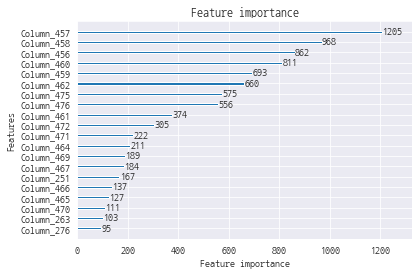

In [ ]:
model = LGBMClassifier(n_estimators=400)
model.fit(encoded_train, y_train, verbose = 1)

plot_importance(model, max_num_features = 20)

모델의 정확도 (언더샘플링 된 데이터의 Validation set 기준)

In [ ]:
y_pred = model.predict(encoder.transform(X_valid))
accuracy_score(y_valid, y_pred)

0.801563873177547

모델의 f1 score와, confusion_matrix (언더샘플링 된 데이터 기준)

In [ ]:
f1 = f1_score(y_valid, y_pred)
print(f'f1 score : {f1}')

print(classification_report(y_valid, y_pred))

f1 score : 0.8080394123032654
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79    110943
         1.0       0.78      0.84      0.81    110942

    accuracy                           0.80    221885
   macro avg       0.80      0.80      0.80    221885
weighted avg       0.80      0.80      0.80    221885



모델의 f1 score와, confusion_matrix (train 세트 전체 데이터 기준)

In [ ]:
f_y_pred = model.predict(encoder.transform(full_data_train))
f_y_test = train_target.values

f_f1 = f1_score(f_y_test, f_y_pred)
print(f'f1 score : {f_f1}')

print(classification_report(f_y_test, f_y_pred))

f1 score : 0.2836180006551382
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86   9709675
         1.0       0.17      0.84      0.28    554711

    accuracy                           0.77  10264386
   macro avg       0.58      0.80      0.57  10264386
weighted avg       0.94      0.77      0.83  10264386



해당 모델의 결과로 출력된 test 예측값 저장.

In [ ]:
# 예측값 반환
X_test = encoder.transform(full_data_test)

test_pred = model.predict(X_test)

print(test_pred)

with open('BASE_LGBM_test_pred.pickle', 'wb') as f:
    pickle.dump(test_pred, f, pickle.HIGHEST_PROTOCOL)

[1. 1. 1. ... 0. 0. 1.]


## 3.5 LGBM 단순 모델링의 중요변수 플롯 재표현.

ONEHOT 인코딩 이후에 이전 열값 꺼내오는 함수 사용.

In [ ]:
# 중요변수 플롯 이름 나오게 그리기.
# column transfomer 의 열이름 반환하기 코드 => 중요변수 플롯에 이름이 없음.
# https://johaupt.github.io/blog/columnTransformer_feature_names.html
import warnings
import sklearn
import pandas as pd
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                          "provide get_feature_names. "
                          "Will return input column names if available"
                          % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

# 라벨 인코더의 열값은 다음과 같이 꺼내지고
get_feature_names(encoder)

# x0~x30 까지의 변수명은 다음과 같다.
full_data_train.columns

# 뒤의 숫자값(라벨 값을 들고있는 변수는) 다음과 같다.
categorical_names

C:\Users\styli\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=int64),
 1: array([  1,   4,   5,   7,   8,  12,  13,  15,  16,  19,  20,  21,  22,
         24,  25,  26,  29,  30,  31,  33,  35,  36,  38,  39,  40,  42,
         43,  46,  47,  48,  49,  51,  52,  53,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  67,  68,  70,  71,  75,  76,  78,
         79,  80,  81,  82,  85,  86,  90,  91,  92,  93,  94,  96,  98,
        100, 101, 102, 103, 105, 107, 108, 110, 111, 113, 114, 116, 118,
        119, 121, 123, 124, 126, 127, 128, 129, 130, 131, 134, 136, 137,
        138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 150, 152, 157,
        159, 161, 162, 163, 164, 166, 168, 169, 170, 171, 174, 175, 176,
        178, 181, 183, 184, 185, 186, 

중요변수 플롯에 들어가는 데이터셋 제작.

In [ ]:
encode_names = get_feature_names(encoder)
encode_names_transform = []
for i in encode_names:
    if i[0] == 'x':
        encode_names_transform.append(full_data_train.columns[int(i[1:])])
    else:
        cat, val = i[6:].split('_') # 'enc__x' 까지는 글자수 고정이므로, 떼고 구분.
        cat = int(cat) # 해당 숫자는 categorical_names에 들어간 순서대로 할당되어 있는것. categorical_names의 열 변수를 tmpline으로 서술.
        tmpline = ['bank_id', 'product_id', 'gender', 'income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation', 'latest_os', 'latest_version']
        cat_str = tmpline[cat]
        cat_idx = [i for i in full_data_train.columns].index(cat_str)
        val_dict = categorical_names[cat_idx]
        val_str = val_dict[int(val)]
        encode_names_transform.append(str(cat_str) + '_' + str(val_str))

del i, cat, val, cat_str, cat_idx, val_dict, val_str, tmpline

# print(encode_names_transform)

중요변수 플롯 그리기.

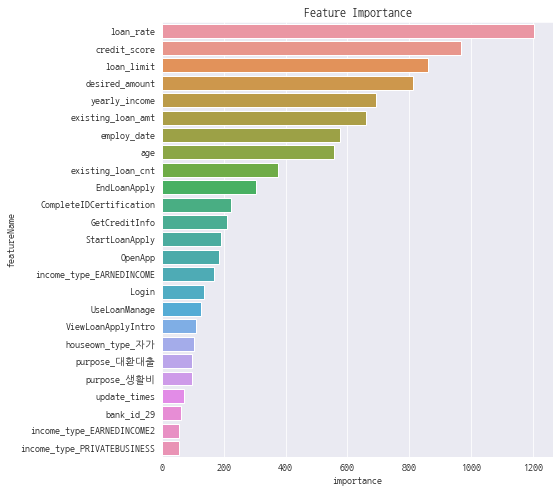

In [ ]:
# 다시 그린 중요변수 플롯.
# 모델의 중요변수를 그릴때 열이름은 model.feature_name_ / 중요도는 model.feature_importances_ 이다.

plt.rc('font',family='NanumGothicCoding')

plot_df = pd.concat([pd.Series(encode_names_transform), pd.Series(model.feature_importances_)], axis=1)
plot_df.columns = ['featureName', 'importance']
plot_df = plot_df.sort_values('importance', ascending = False).head(25)

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="featureName", data=plot_df)

plt.show()

## 3.6 LIME을 이용한 단순 LGBM 결과 시각화.

라임 테이블 해석기 모듈 세팅.

In [ ]:
predict_fn = lambda x: model.predict_proba(encoder.transform(x)).astype(float)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names = feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=3)

valid셋에 존재하는 특정값에 대해 어떤식으로 예측하였는지 해석.

In [ ]:
i = 1021
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn, num_features=20)
exp.show_in_notebook(show_all=False)
exp.save_to_file('lime.html')

# exp.as_pyplot_figure()
# exp.as_html()
# exp.save_to_file('lime.html')
# exp.as_pyplot_figure()
# exp.as_list() # 그림 그릴때 사용하는 값들
# exp.available_labels() # 이 요소가 무슨 값일지.

C:\Users\styli\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# 4. LGBM GRIDSEARCH

데이터는 그대로 사용. 그리드 서치 실시.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# 모델 gridsearchCV 이용 최적 모델 탐색.

grid_model = LGBMClassifier()
params = {'n_estimators':[700,800,900,1000], 'num_leaves':[120,140,160,180], 'min_child_samples':[20,25,30],'max_depth':[-1,10,20,30],
          'learning_rate':[0.05,0.1,0.2], 'reg_alpha':[0, 0.01,0.02], 'reg_lambda' : [0, 0.01, 0.02]}
clf = RandomizedSearchCV(grid_model, params, scoring='accuracy', n_iter=200, cv=5, verbose = 2, refit = True)
clf.fit(encoder.transform(undersampled_data), undersampled_target)
print(clf.best_params_)

with open('LGBM_GRID_SEARCH(random+onehot+rep2)_MODELS.pickle', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)

# predict(X) : 제일 좋은 성능을 낸 모델로 예측
# predict_proba(X) : 제일 좋은 성능을 낸 모델로 predict_proba() 호출
# best_estimator_ : 가장 좋은 성능을 낸 모델 반환

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=180, reg_alpha=0, reg_lambda=0.01; total time=  29.3s
[CV] END learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=180, reg_alpha=0, reg_lambda=0.01; total time=  24.4s
[CV] END learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=180, reg_alpha=0, reg_lambda=0.01; total time=  27.6s
[CV] END learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=180, reg_alpha=0, reg_lambda=0.01; total time=  27.1s
[CV] END learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=800, num_leaves=180, reg_alpha=0, reg_lambda=0.01; total time=  25.6s
[CV] END learning_rate=0.2, max_depth=20, min_child_samples=30, n_estimators=900, num_leaves=120, reg_alpha=0, reg_lambda=0.01; total time=  18.3s
[CV] END learning_rate=0.2, max_depth=20, min_chi

탐색 결과로 찾은 하이퍼 파라미터
{'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 180, 'n_estimators': 1000, 'min_child_samples': 25, 'max_depth': 10, 'learning_rate': 0.1}

In [ ]:
with open("LGBM_GRID_SEARCH(random+onehot+rep2)_MODELS.pickle", 'rb') as f:
    clf = pickle.load(f)

full_data_train에 대한 f1_score와 confusion_matrix 결과.

In [ ]:
f_y_pred = clf.predict(encoder.transform(full_data_train))
f_y_test = train_target.values

f_f1 = f1_score(f_y_test, f_y_pred)
print(f'f1 score : {f_f1}')

print(classification_report(f_y_test, f_y_pred))

f1 score : 0.31689271474567504
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88   9709675
         1.0       0.19      0.89      0.32    554711

    accuracy                           0.79  10264386
   macro avg       0.59      0.84      0.60  10264386
weighted avg       0.95      0.79      0.85  10264386



중요변수 플롯 그리기.

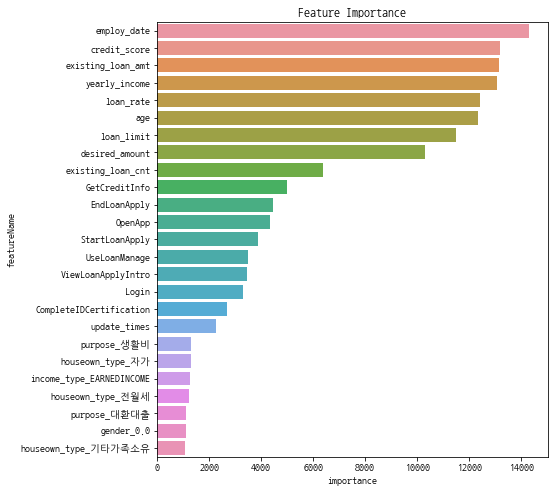

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',family='NanumGothicCoding')

plot_df = pd.concat([pd.Series(encode_names_transform), pd.Series(clf.best_estimator_.feature_importances_)], axis=1)
plot_df.columns = ['featureName', 'importance']
plot_df = plot_df.sort_values('importance', ascending = False).head(25)

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="featureName", data=plot_df)

plt.show()

테스트 데이터 예측. 데이터 프레임으로 반환.

In [ ]:
test_pred = clf.predict(encoder.transform(full_data_test))

full_data_test_pred = pd.concat([test_appid, test_usrid, full_data_test, pd.Series(test_pred,name = 'is_applied')], axis = 1)

full_data_test_pred.to_csv('full_data_test_pred.csv', index = False)

lime을 활용한 예측 모델 설명.

예측기 제작.

In [ ]:
predict_fn2 = lambda x: clf.predict_proba(encoder.transform(x)).astype(float)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names = feature_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=3)

예측결과 예제 1

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\Nyoths\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


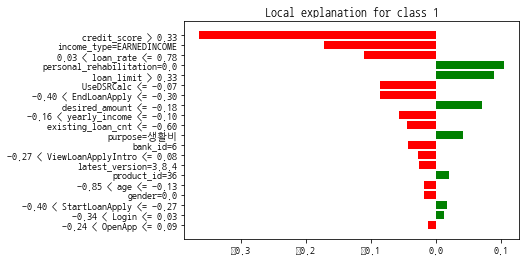

In [ ]:
i = 7176
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn2, num_features=20)
exp.as_pyplot_figure()
exp.save_to_file('lime_output1.html')

예측결과 예제 2

C:\Users\Nyoths\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\Nyoths\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


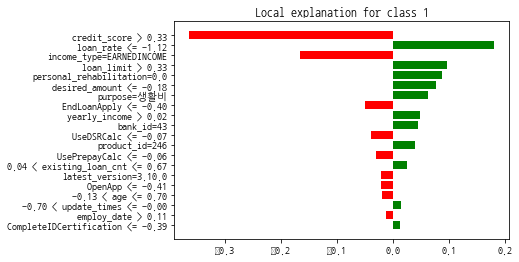

In [ ]:
i = 4042
exp = explainer.explain_instance(X_valid.iloc[i], predict_fn2, num_features=20)
exp.as_pyplot_figure()
exp.save_to_file('lime_output2.html')

LIME 예측기로 예측한 가장 중요한 요인 고르기.
테이블 작업.(pred0이 0개라 concat 오류 무시하고 작업에도 상관없음)

In [ ]:
# 개별 요소 예측. 중요변수 판단(1만개 대상 샘플링한 결과를 일반화.)
import warnings
warnings.filterwarnings(action='ignore')

pred_df = undersampled_data.sample(10000)

pred0_df = []
pred1_df = []
pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance'])
for i in tqdm(range(len(pred_df))):
    exp = explainer.explain_instance(pred_df.iloc[i], predict_fn2, num_features=20)
    if exp.available_labels() == [1]:
        pred1_df.append(pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance']))

    elif exp.available_labels() == [0]:
        pred0_df.append(pd.DataFrame(exp.as_list(), columns = ['Feature', 'Importance']))

print(f'undersampleing 데이터 수 : {len(undersampled_data)}')
print(f'0번 예측 개수 : {len(pred0_df)}')
print(f'1번 예측 개수 : {len(pred1_df)}')

100%|██████████| 10000/10000 [10:08:04<00:00,  3.65s/it] 

undersampleing 데이터 수 : 1109422
0번 예측 개수 : 0
1번 예측 개수 : 10000


ValueError: No objects to concatenate

In [ ]:
pred1_df = pd.concat(pred1_df, axis = 0)
pred1_df.to_csv('pred1df_feature_importance')

중요변수 순위.

개별로 확인.

In [ ]:
pred1_df.groupby('Feature').mean().sort_values('Importance')

,Importance
Feature,
credit_score > 0.33,-0.367507
bank_id=28,-0.286854
product_id=16,-0.227415
product_id=81,-0.191975
bank_id=34,-0.187687
...,...
latest_version=2.28.2,0.180198
bank_id=2,0.186122
loan_rate <= -1.12,0.189327


In [ ]:
pred1_df.groupby('Feature').mean().sort_values('Importance', ascending = False)

,Importance
Feature,
credit_score <= -1.03,0.298085
bank_id=4,0.253912
loan_rate <= -1.12,0.189327
bank_id=2,0.186122
latest_version=2.28.2,0.180198
...,...
bank_id=34,-0.187687
product_id=81,-0.191975
product_id=16,-0.227415


플롯으로 표현.

pred1

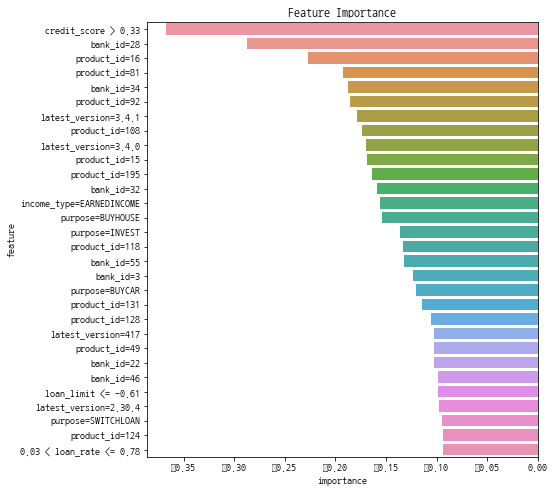

In [ ]:
plt.rc('font',family='NanumGothicCoding')

plot_df = pred1_df.groupby('Feature').mean().sort_values('Importance').head(30).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()

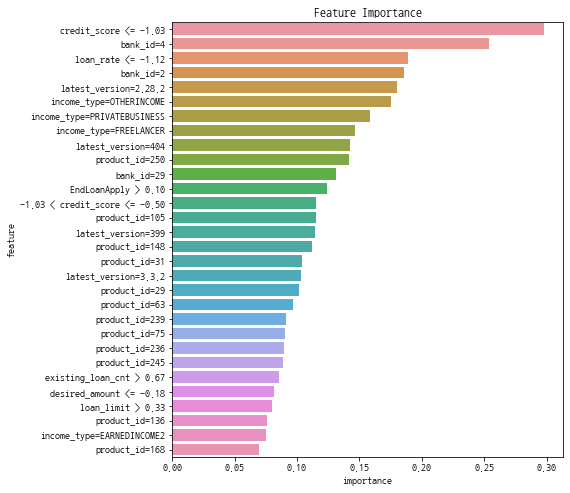

In [ ]:
plt.rc('font',family='NanumGothicCoding')

plot_df = pred1_df.groupby('Feature').mean().sort_values('Importance', ascending = False).head(30).reset_index()
plot_df.columns = ['feature', 'importance']

plt.figure(figsize=(7,8))
plt.title('Feature Importance')
sns.barplot(x="importance", y="feature", data=plot_df)

plt.show()